# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [17]:
import pandas as pd

factories = pd.read_csv("tbl_factory.csv", index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [18]:
warehouses = pd.read_csv("tbl_warehouse.csv")
warehouses

,WHID,WHName,WHSupply,WHRegion
0,WH00001,杉並倉庫,35,関東
1,WH00002,品川倉庫,41,関東
2,WH00003,豊洲倉庫,42,関東
3,WH00004,郡山倉庫,60,東北
4,WH00005,仙台倉庫,72,東北
5,WH00006,山形倉庫,65,東北


In [19]:
cost = pd.read_csv("rel_cost.csv")
cost.head()

,RCostID,FCID,WHID,Cost
0,1,FC00001,WH00001,0.4
1,2,FC00001,WH00002,0.8
2,3,FC00001,WH00003,1.5
3,4,FC00002,WH00001,0.9
4,5,FC00002,WH00002,0.8


In [20]:
trans = pd.read_csv("tbl_transaction.csv")
trans.head()

,TRID,TransactionDate,ToFC,FromWH,Quantity
0,0,2019-01-01 02:11:10,FC00004,WH00003,33
1,1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2,2019-01-01 06:32:32,FC00006,WH00004,31
3,3,2019-01-01 07:17:06,FC00002,WH00003,18
4,4,2019-01-01 07:52:18,FC00001,WH00002,30


In [21]:
join_data = pd.merge(trans, cost, left_on=["ToFC", "FromWH"], right_on=["FCID", "WHID"], how="left")
join_data.head()

,TRID,TransactionDate,ToFC,FromWH,Quantity,RCostID,FCID,WHID,Cost
0,0,2019-01-01 02:11:10,FC00004,WH00003,33,12,FC00004,WH00003,1.1
1,1,2019-01-01 06:12:42,FC00007,WH00006,19,21,FC00007,WH00006,1.3
2,2,2019-01-01 06:32:32,FC00006,WH00004,31,16,FC00006,WH00004,0.9
3,3,2019-01-01 07:17:06,FC00002,WH00003,18,6,FC00002,WH00003,1.6
4,4,2019-01-01 07:52:18,FC00001,WH00002,30,2,FC00001,WH00002,0.8


In [22]:
join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", how="left")
join_data.head()

,TRID,TransactionDate,ToFC,FromWH,Quantity,RCostID,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,0,2019-01-01 02:11:10,FC00004,WH00003,33,12,FC00004,WH00003,1.1,横須賀工場,25,関東
1,1,2019-01-01 06:12:42,FC00007,WH00006,19,21,FC00007,WH00006,1.3,那須工場,25,東北
2,2,2019-01-01 06:32:32,FC00006,WH00004,31,16,FC00006,WH00004,0.9,山形工場,30,東北
3,3,2019-01-01 07:17:06,FC00002,WH00003,18,6,FC00002,WH00003,1.6,木更津工場,29,関東
4,4,2019-01-01 07:52:18,FC00001,WH00002,30,2,FC00001,WH00002,0.8,東京工場,28,関東


In [23]:
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
join_data = join_data[["TransactionDate", "Quantity", "Cost", "ToFC", "FCName", "FCDemand", "FromWH", "WHName", "WHSupply", "WHRegion"]]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [24]:
kanto = join_data.loc[join_data["WHRegion"]=="関東"]
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [25]:
tohoku = join_data.loc[join_data["WHRegion"]=="東北"]
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [26]:
print("関東支社の総コスト：" + str(kanto["Cost"].sum()) + "万円")
print("東北支社の総コスト：" + str(tohoku["Cost"].sum()) + "万円")

関東支社の総コスト：2189.3万円
東北支社の総コスト：2062.0万円


In [27]:
print("関東支社の総部品輸送個数：" + str(kanto["Quantity"].sum()) + "個")
print("東北支社の総部品輸送個数：" + str(tohoku["Quantity"].sum()) + "個")

関東支社の総部品輸送個数：49146個
東北支社の総部品輸送個数：50214個


In [28]:
tmp = (kanto["Cost"].sum() / kanto["Quantity"].sum()) * 10000
print("関東支社の部品1つ当たりの輸送コスト：" + str(int(tmp)) + "円")
tmp = (tohoku["Cost"].sum() / tohoku["Quantity"].sum()) * 10000
print("東北支社の部品1つ当たりの輸送コスト：" + str(int(tmp)) + "円")

関東支社の部品1つ当たりの輸送コスト：445円
東北支社の部品1つ当たりの輸送コスト：410円


In [29]:
cost_chk = pd.merge(cost, factories, on="FCID", how="left")
print("東京支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="関東"].mean()) + "万円")
print("東北支社の平均輸送コスト：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="東北"].mean()) + "万円")

東京支社の平均輸送コスト：1.075万円
東北支社の平均輸送コスト：1.05万円


### ノック５３：ネットワークを可視化してみよう

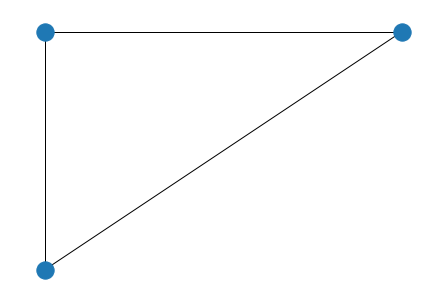

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")

pos = {}
pos["nodeA"] = (0,0)
pos["nodeB"] = (1,1)
pos["nodeC"] = (0,1)

nx.draw(G,pos)

plt.show()

### ノック５４：ネットワークにノードを追加してみよう

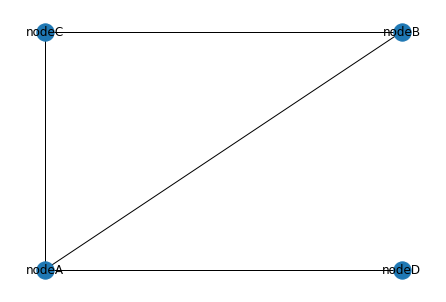

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")
G.add_node("nodeD")

G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")
G.add_edge("nodeA","nodeD")

pos = {}
pos["nodeA"] = (0,0)
pos["nodeB"] = (1,1)
pos["nodeC"] = (0,1)
pos["nodeD"] = (1,0)

nx.draw(G,pos, with_labels=True)

plt.show()

### ノック５５：ルートの重みづけを実施しよう

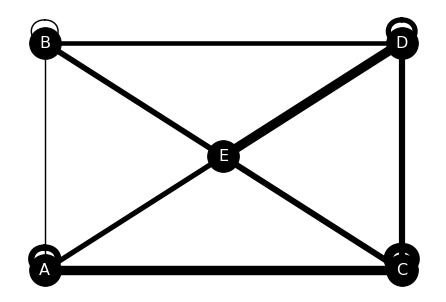

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

df_w = pd.read_csv('network_weight.csv')
df_p = pd.read_csv('network_pos.csv')

size = 10
edge_weights = []
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_weights.append(df_w.iloc[i][j]*size)

G = nx.Graph()

for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i],df_w.columns[j])

pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

nx.draw(G, pos, with_labels=True, font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

plt.show()

### ノック５６：輸送ルート情報を読み込んでみよう

In [1]:
import pandas as pd

df_tr = pd.read_csv("trans_route.csv",index_col="工場")
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

### ノック５８：輸送コスト関数を作成しよう

### ノック５９：制約条件を作ってみよう

### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう